In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

inspector = inspect(engine)
inspector.get_table_names()

columns = inspector.get_columns('measurement')

for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Calculate the date 1 year ago from the last data point in the database

max_dt = session.query(Measurement.date).\
         group_by(Measurement.date).\
         order_by(desc(Measurement.date)).\
         first()

max_dt_v = datetime.strptime((str(np.ravel(max_dt)[0])), '%Y-%m-%d') 

one_year_b4 = max_dt_v - dt.timedelta(days=366)

print(one_year_b4)

2016-08-22 00:00:00


([], <a list of 0 Text xticklabel objects>)

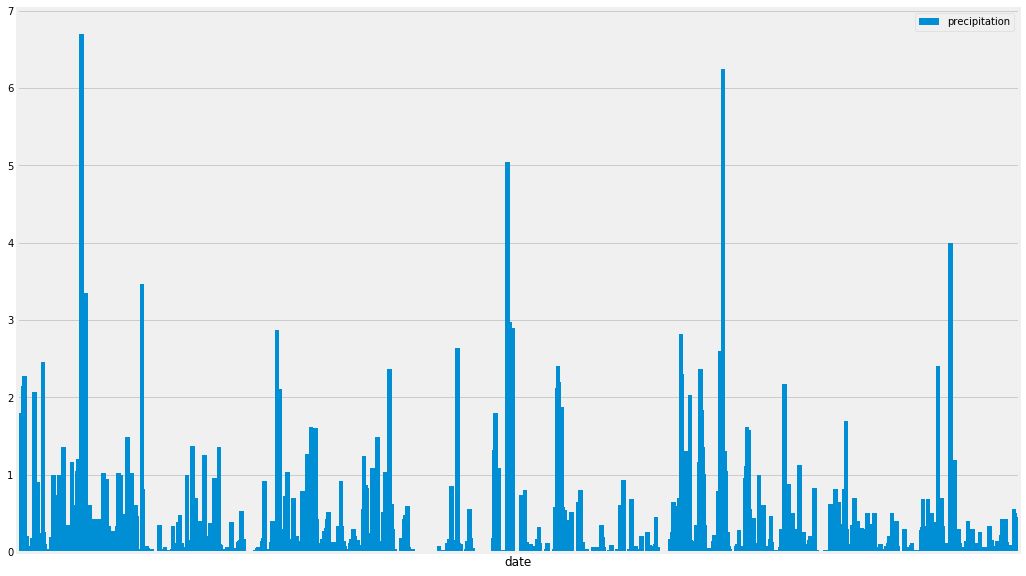

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Perform a query to retrieve the data and precipitation scores

data = session.query(Measurement.date , Measurement.prcp ).\
            filter(Measurement.date >= one_year_b4).\
            order_by(Measurement.date).\
            all() 

# Save the query results as a Pandas DataFrame and set the index to the date column

data_df = pd.DataFrame(data, columns=['date', 'precipitation'])
data_df.set_index('date', inplace=True, )

# Sort the dataframe by date

data_df_sort = data_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
data_df_sort.plot(kind='bar', figsize=(16,10), width=10)

plt.xticks([])

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data

data_df.describe()


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
    
session.query(Station.station).group_by(Station.station).count()


9

In [16]:
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.query(Station.station, func.count(Measurement.station) ).\
        group_by(Measurement.station).\
        filter(Measurement.station == Station.station).\
        order_by(desc(func.count(Measurement.station))).\
        all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

session.query( func.min(Measurement.tobs), func.max(Measurement.tobs) , func.avg(Measurement.tobs) ).\
        filter(Measurement.station == 'USC00519281').\
        all()


[(54.0, 85.0, 71.66378066378067)]

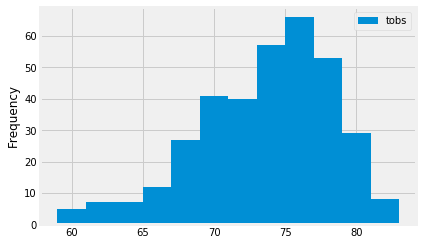

In [92]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_data = session.query( Measurement.tobs ).\
                    filter(Measurement.date >= one_year_b4).\
                    filter(Measurement.station == 'USC00519281').\
                    all() 

temp_df = pd.DataFrame(temp_data)

temp_df.plot(kind='hist',bins=12)

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

myvac = calc_temps('2016-08-23', '2016-09-01')
print(myvac)

list

[78.32307692307693] 13.0
[0]


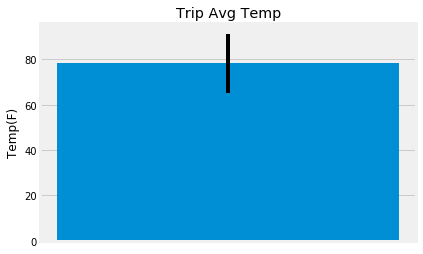

In [42]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

y = [myvac[0][1]]
yerror = [myvac[0][2]- myvac[0][0]]
l = ['temp']
x_pos = np.arange(len(l))

plt.title('Trip Avg Temp')
plt.bar(x_pos,y, yerr=yerror)
plt.ylabel('Temp(F)')
plt.xticks([])
plt.show()

In [157]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_start_prev_yr = datetime.strptime( ('2016-08-23'), '%Y-%m-%d' )  - dt.timedelta(days=366)

trip_end_prev_yr   = datetime.strptime( ('2016-09-01'), '%Y-%m-%d' )  - dt.timedelta(days=366)

session.query( Measurement.station , Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp) ).\
                    group_by(Measurement.station).\
                    filter(Measurement.date > trip_start_prev_yr).\
                    filter(Measurement.date < trip_end_prev_yr).\
                    filter(Measurement.station == Station.station).\
                    order_by(desc(func.sum(Measurement.prcp))).\
                    all()


2015-08-23 00:00:00 2015-09-01 00:00:00


[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  8.929999999999998),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  7.919999999999999),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  6.57),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  4.21),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2.35),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  2.1),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 1.92),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 1.5)]

## Optional Challenge Assignment

In [43]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [63]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
import datetime

# Set the start and end date of the trip
start_dt = '2016-08-25'
end_dt = '2016-09-01'

# Use the start and end date to create a range of dates
start = datetime.datetime.strptime(start_dt, "%Y-%m-%d")
end = datetime.datetime.strptime(end_dt, "%Y-%m-%d")
date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]

mm_dd_yy_list = []
for date in date_generated:
    mm_dd_yy_list.append(date.strftime("%Y-%m-%d"))
    
# Strip off the year and save a list of %m-%d strings
mm_dd_list = []
for date in date_generated:
    mm_dd_list.append(date.strftime("%m-%d"))
    
# Loop through the list of %m-%d strings and calculate the normals for each date
dn_l = []
for x in mm_dd_list:
    dn_l.append(daily_normals(x)[0])
    
print(dn_l)    

[(69.0, 76.96078431372548, 82.0), (71.0, 76.56862745098039, 84.0), (68.0, 76.28301886792453, 84.0), (67.0, 76.73469387755102, 86.0), (70.0, 76.23529411764706, 85.0), (68.0, 76.41666666666667, 84.0), (67.0, 76.84, 85.0)]


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
date_df = pd.DataFrame(mm_dd_yy_list, columns=['date'])    

stats_df = pd.DataFrame(dn_l, columns=['tmin', 'tavg', 'tmax'])

new_df = pd.concat([date_df,stats_df], axis = 1)

new_df.head(10)

new_df.set_index('date')

,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


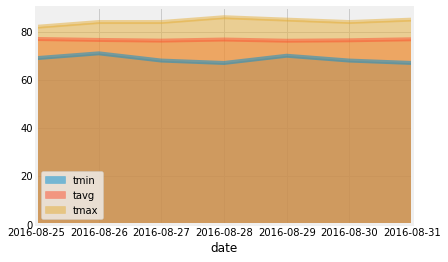

In [91]:
# Plot the daily normals as an area plot with `stacked=False`
new_df.plot.area(x='date', stacked=False)